# Multiple components fitting with automatic velocity estimate

This is a complete (and complex) example of what can be achieved with the automatic velocity estimation algorithm described in [Martin et al. (2021)](https://doi.org/10.1093/mnras/staa4046). This algorithm permit to estimate the velocity of one or more components along the line of sight. It is both fast and reliable, giving the necessary velocity input for the fitting procedure of objects displaying complex velocity patterns (here the Crab Nebula).

In [1]:
import orcs.process
import numpy as np
import pylab as pl
from importlib import reload
import orb.utils.graph as graph
import orb.utils.io

## load cube

In [2]:
cube = orcs.process.SpectralCube('../M1_2022_SN3.merged.cm1.hdf5')

dev.b308|INFO| CFHT version
dev.b308|INFO| Cube is level 2.5
dev.b308|INFO| shape: (2048, 2064, 847)
dev.b308|INFO| wavenumber calibration: True
dev.b308|INFO| flux calibration: True
dev.b308|INFO| wcs calibration: True


## extract deep frame

dev.b308|INFO| Data written as m1.df.fits in 0.11 s 


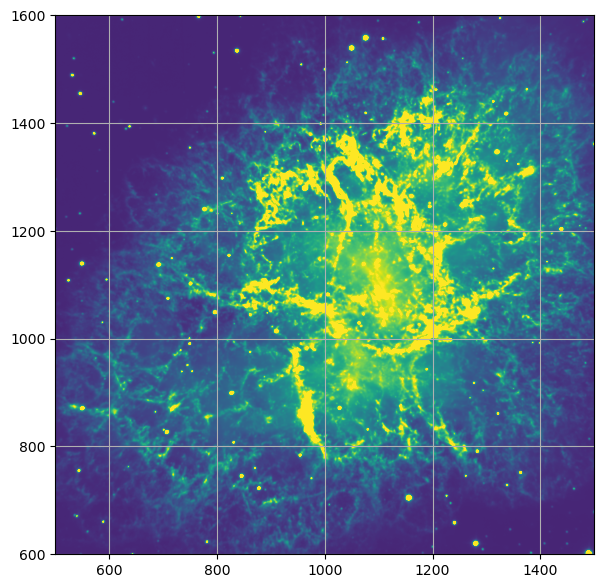

In [3]:
df = cube.get_deep_frame()
df.imshow(wcs=False)
df.to_fits('m1.df.fits')
pl.xlim(500,1500)
pl.ylim(600,1600)
pl.grid()

## extract sky spectrum

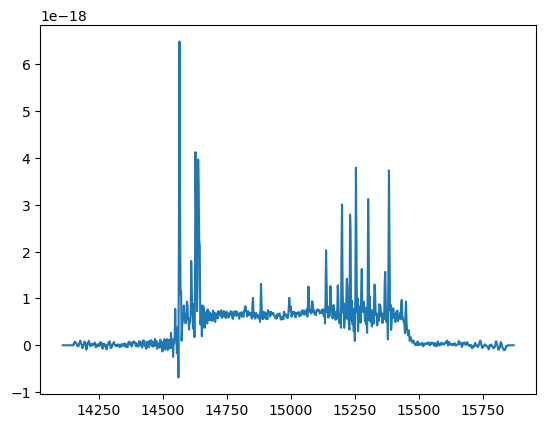

In [4]:
sky1 = cube.get_spectrum(300,1000,r=150, mean_flux=True, median=True)
sky1.plot()
sky1.writeto('sky.hdf5') # write spectrum to disk 
sky1 = orb.fft.Spectrum('sky.hdf5') # read spectrum from disk


## estimate velocities on a single vector with up to 3 velocity components

dev.b308|INFO| estimated velocities: [1394.0285954583683, 1162.7417998317915, -1053.4062237174096]


=== Fit results ===
lines: ['[NII]6548', '[NII]6584', 'H3', '[SII]6717', '[SII]6731', '[NII]6548', '[NII]6584', 'H3', '[SII]6717', '[SII]6731', '[NII]6548', '[NII]6584', 'H3', '[SII]6717', '[SII]6731'], fmodel: sinc
iterations: 161, fit time: 1.99e-01 s
number of free parameters: 19, BIC: -2.93457e+04, chi2: 5.22e-37
Velocity (km/s): [1394.03(98) 1394.03(98) 1394.03(98) 1394.03(98) 1394.03(98) 1163.4(1.0)
 1163.4(1.0) 1163.4(1.0) 1163.4(1.0) 1163.4(1.0) -1053.3(1.7) -1053.3(1.7)
 -1053.3(1.7) -1053.3(1.7) -1053.3(1.7)] 
Flux: [1.38(17)e-15 4.62(17)e-15 1.12(17)e-15 4.4(1.8)e-16 3.6(1.8)e-16
 2.42(17)e-15 4.01(17)e-15 9.8(1.7)e-16 3.1(1.7)e-16 4.9(1.8)e-16
 3.0(1.6)e-16 1.35(17)e-15 1.65(16)e-15 9.3(1.7)e-16 1.42(17)e-15]
Broadening (km/s): [nan +- nan nan +- nan nan +- nan nan +- nan nan +- nan nan +- nan
 nan +- nan nan +- nan nan +- nan nan +- nan nan +- nan nan +- nan
 nan +- nan nan +- nan nan +- nan]
SNR (km/s): [ 8.30487822 27.43659442  6.68909642  2.50369318  2.04827803 14.52643

(14700.0, 15400.0)

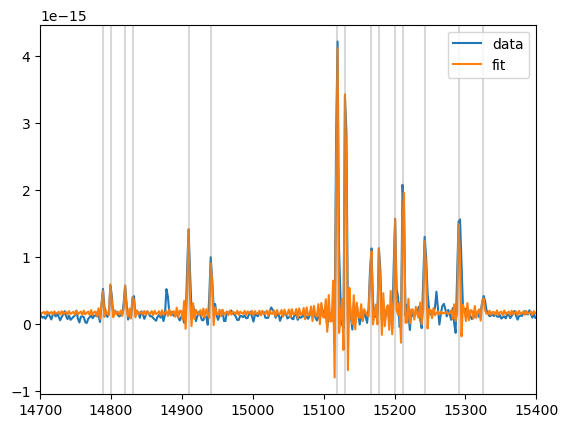

In [10]:
NCOMP = 3
lines = ['[NII]6548', '[NII]6584', 'Halpha', '[SII]6717', '[SII]6731'] 

ix, iy = 1140, 1200 # x, y position to check
threshold = 4 # loosely related to mean SNR in all 5 lines

spec = cube.get_spectrum(ix, iy, 3)
spec.data -= sky1.data # subtract sky spectrum
fit = spec.autofit(lines, vel_range=[-2500,2500], max_comps=NCOMP, threshold=threshold, prod=True)

print(fit)
pl.figure()
spec.plot(label='data')
fit.get_spectrum().plot(label='fit')
for ipos in fit['lines_params'][:,2]:
    pl.axvline(ipos, c='gray', alpha=0.3)

pl.legend(loc='upper right')
pl.xlim(14700, 15400)

## Estimation of the different components velocity 

Estimation is best done for 3 different groups of lines since sometimes only SII lines are strong enough, sometimes they simply disappear leaving only Halpha and NII. The following is thus run 3 times and its results put in different folders (`all`, `ha_nii`, `sii`).

The `binning` parameter can be set to a value above 1 to do a quick estimate especially on objects where the velocity gradient is small (e.g. a galaxy). In general, on a galaxy we can use a safe value of 3 or 4 for the binning, making the estimate 10 to 16 times faster (i.e. a few minutes).In this example we started with 5 and 3 binning values to check the validity of the input parameter before going to a 1x1 binning.

In [5]:
# a region is defined (ds9 style) to keep the estimate into it.
region = 'polygon(438.09517,1072.4537,602.32429,1400.9119,811.34317,1511.3933,906.89466,1929.4311,1115.9135,1902.5572,1115.9135,1693.5384,1181.6052,1693.5384,1268.1987,1741.3141,1390.6241,1801.0338,1632.4888,1708.4683,1668.3206,1541.2532,1745.9562,1448.6877,1734.0122,1111.2715,1742.9702,961.97229,1513.0494,624.5561,847.17498,466.29894,417.19328,576.78035,342.54368,800.72915)'
p = cube.estimate_parameters_in_region(
    region,
    #['[NII]6584', '[NII]6548', 'Halpha', '[SII]6717', '[SII]6731'],
    #['[NII]6584', '[NII]6548', 'Halpha'],
    ['[SII]6717', '[SII]6731'],
    vel_range=[-2000,2000], subtract_spectrum=sky1.data, binning=1, max_comps=6, threshold=3)

dev.4cc3|INFO| Init of the parallel processing server with 8 threads
dev.4cc3|INFO| passed mapped kwargs : []
dev.4cc3|INFO| 1463 rows to fit


 [==========] [100%] [completed in 3h2m26s]                                   

dev.4cc3|INFO| Closing parallel processing server


dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_velocity.0.fits in 0.33 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_SII6717.0.fits in 0.11 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_SII6731.0.fits in 0.11 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_velocity.1.fits in 0.11 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_SII6717.1.fits in 0.11 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_SII6731.1.fits in 0.11 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_velocity.2.fits in 0.12 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimated_SII6717.2.fits in 0.11 s 
dev.4cc3|INFO| Data written as ./Crab-nebula_SN3/Crab-nebula_SN3.SpectralCube.estimat

## build a velocity map considering all three estimations. 

A lot of components have been detected multiple times since a component display in all the lines will be detected by all the different runs. We must now detect and remove the duplicates

In [13]:
def get_cube(ifolder):
    NCOMP = 6
    maps = list()
    for icomp in range(NCOMP):
        imap = orb.utils.io.read_fits('Crab-nebula_SN3_2022/{}/Crab-nebula_SN3.SpectralCube.estimated_velocity.{}.fits'.format(ifolder, icomp))
        maps.append(imap)
    return np.dstack(maps)
    
map_all = get_cube('all')
map_nii = get_cube('ha-nii')
map_sii = get_cube('sii')
    

In [14]:
stop = False

precision = 3e5 / cube.params.resolution / 4 # channel size in km/s

mask = np.sum(~np.isnan(map_all), axis=2) + np.sum(~np.isnan(map_nii), axis=2) + np.sum(~np.isnan(map_sii), axis=2)

map_final = np.full((map_all.shape[0],map_all.shape[1],12) , np.nan)

for ix in range(map_all.shape[0]):
    for iy in range(map_all.shape[1]):
        if mask[ix, iy] == 0: continue
        
        #if mask[ix, iy] > 6:
        vels = np.array(list(map_all[ix,iy,:]) + list(map_nii[ix,iy,:]) + list(map_sii[ix,iy,:]))
        vels = list(vels[~np.isnan(vels)])
        kept = list()
            
        while len(vels) > 0:
            ivel = vels.pop(0)
            kept.append(ivel)
            vels = [iivel for iivel in vels if np.abs(iivel - ivel) > precision]
        
        map_final[ix, iy, :len(kept)] = kept
 
        
        if stop: break
    if stop: break
    
orb.utils.io.write_fits('velocity_estimate.fits', map_final)

dev.b308|INFO| Data written as velocity_estimate.fits in 2.35 s 


'velocity_estimate.fits'

(500.0, 1600.0)

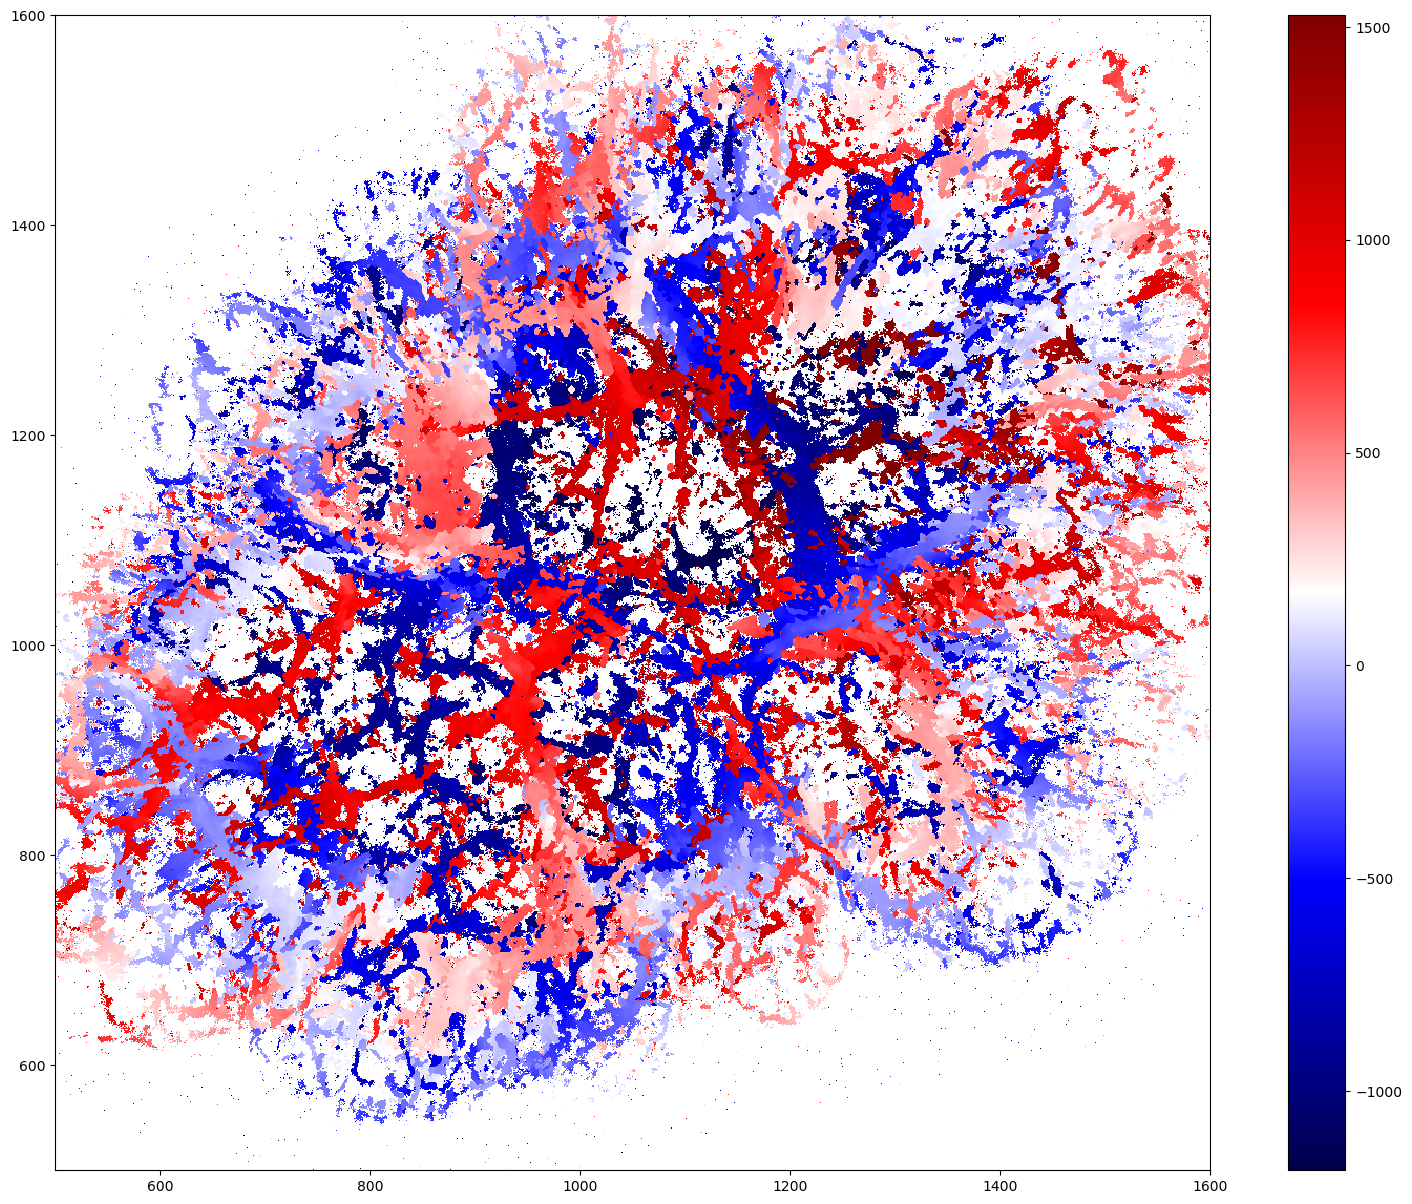

In [20]:
graph.imshow(map_all[:,:,0], figsize=(20,15), interpolation='nearest', cmap='seismic')
pl.colorbar()
pl.ylim(500,1600)
pl.xlim(500,1600)


## Flux is also estimated

(500.0, 1600.0)

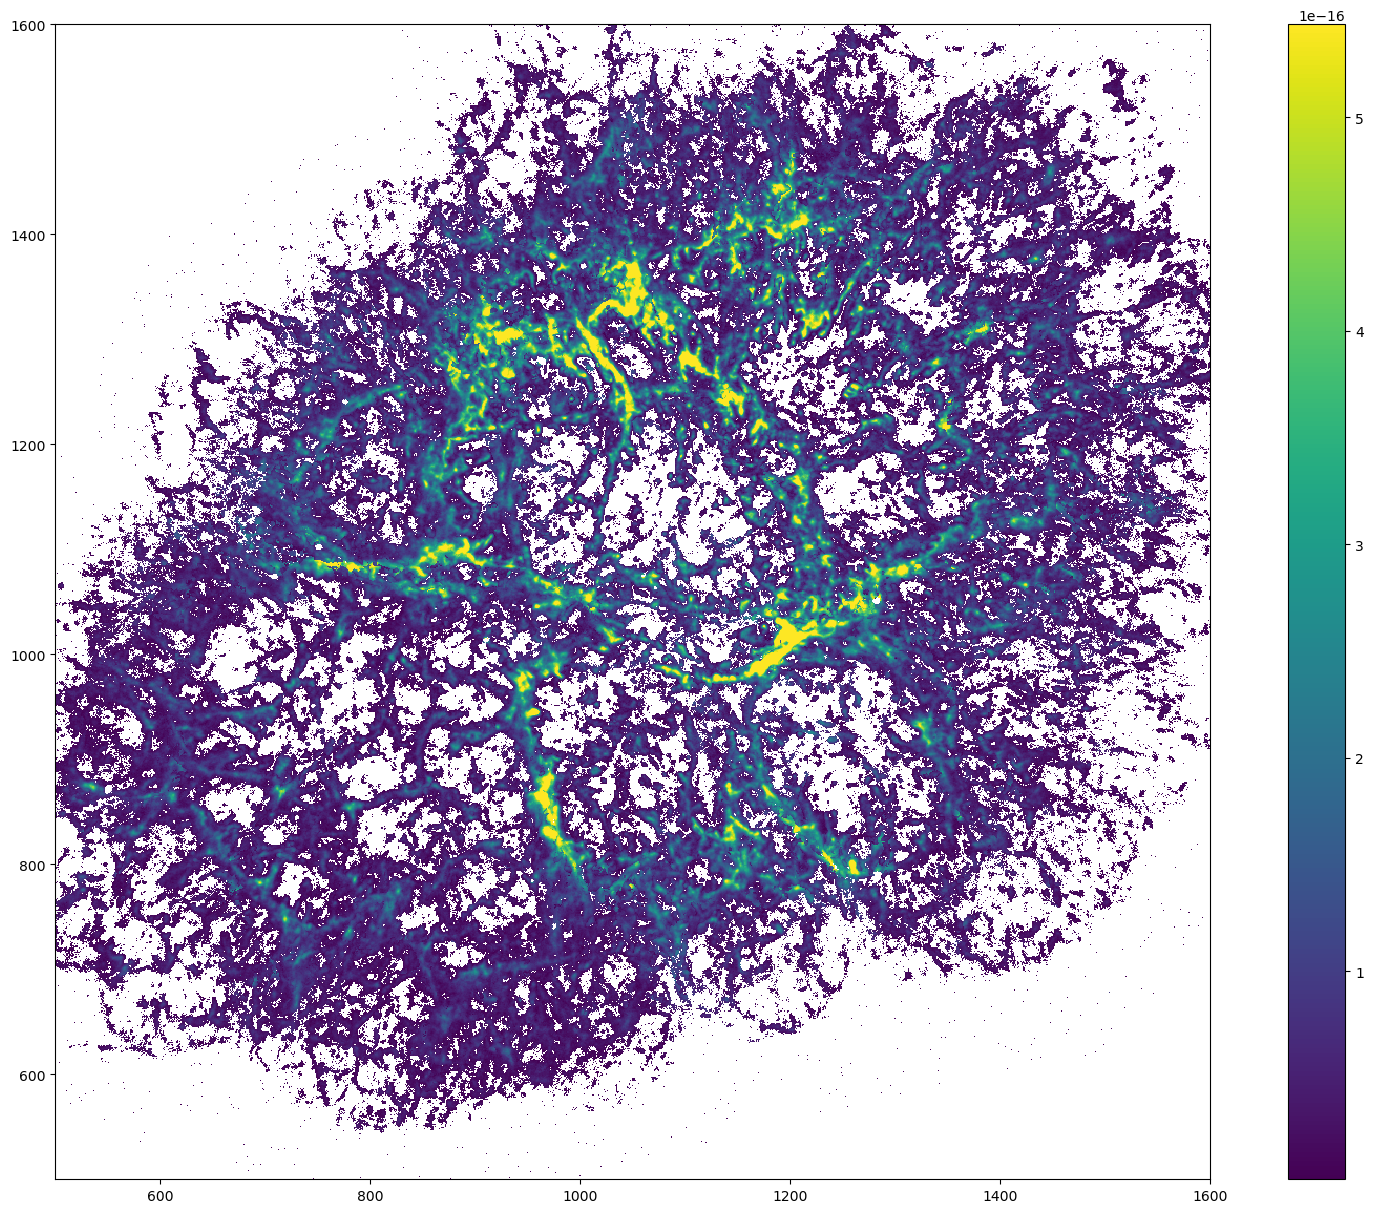

In [33]:
graph.imshow(orb.utils.io.read_fits('Crab-nebula_SN3_2022/all/Crab-nebula_SN3.SpectralCube.estimated_Halpha.0.fits'), figsize=(20,15), interpolation='nearest')
pl.colorbar()
pl.ylim(500,1600)
pl.xlim(500,1600)

## Using the estimated velocity as an input for a single fit

dev.b308|INFO| CFHT version
dev.b308|INFO| Cube is level 2.5
dev.b308|INFO| shape: (2048, 2064, 847)
dev.b308|INFO| wavenumber calibration: True
dev.b308|INFO| flux calibration: True
dev.b308|INFO| wcs calibration: True


[-968.1397705078125, 647.4819946289062, -1638.2755126953125]


dev.b308|WARNING| /home/thomas/miniconda3/envs/orb3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)



Text(0.5, 1.0, 'residual')

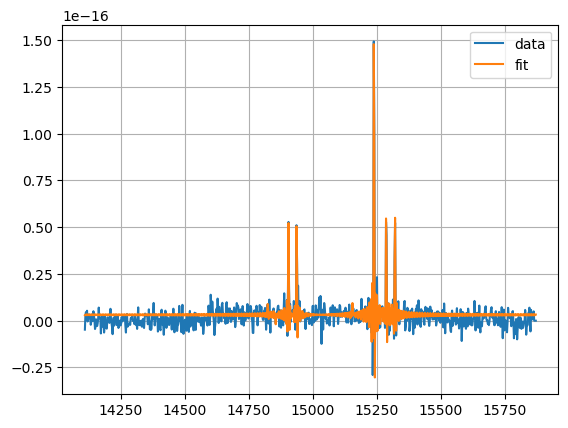

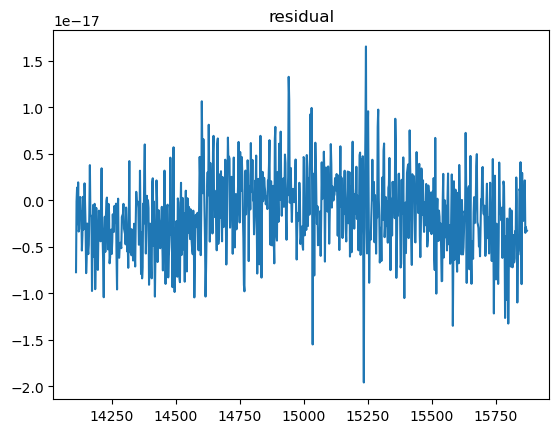

In [43]:
NCOMP = 3
lines = ['[NII]6548', '[NII]6584', 'Halpha', '[SII]6717', '[SII]6731'] 
cube = orcs.process.SpectralCube('../M1_2022_SN3.merged.cm1.hdf5')
amp_ratio = cube.get_amp_ratio_from_flux_ratio('[NII]6583', '[NII]6548', 3)


pos_def = list()
pos_cov = list()
amp_def = list()
amp_guess = list()

map_final = orb.utils.io.read_fits('velocity_estimate.fits')

for i in range(NCOMP):
    pos_cov.append(map_final[ix,iy,i])
    pos_def += (str(i),) * len(lines)
    amp_def += (str(i*len(lines)), str(i*len(lines)),
                 str(i*len(lines)+1), str(i*len(lines)+2),
                 str(i*len(lines)+3))
    amp_guess += (1, amp_ratio, 1, 1, 1)
    
print(pos_cov)

fit = cube.fit_lines_in_spectrum(1000, 1000, 0, lines * NCOMP, pos_def=pos_def, pos_cov=pos_cov, amp_def=amp_def, amp_guess=amp_guess, subtract_spectrum=sky1.data)

pl.plot(fit[0], fit[1],label='data')
fit[2].get_spectrum().plot(label='fit')
pl.legend()
pl.grid()

pl.figure()
pl.plot(fit[0], fit[1].data - fit[2].get_spectrum().data)
pl.title('residual')

## Using the estimated velocity as an input for a complete fit

In [ ]:
NCOMP = 3
lines = ['[NII]6548', '[NII]6584', 'Halpha', '[SII]6717', '[SII]6731'] 
cube = orcs.process.SpectralCube('../M1_2022_SN3.merged.cm1.hdf5')
amp_ratio = cube.get_amp_ratio_from_flux_ratio('[NII]6583', '[NII]6548', 3)


pos_def = list()
pos_cov = list()
amp_def = list()
amp_guess = list()

map_final = orb.utils.io.read_fits('velocity_estimate.fits')
sky1 = orb.fft.Spectrum('sky.hdf5')

for i in range(NCOMP):
    pos_cov.append(map_final[:,:,i])
    pos_def += (str(i),) * len(lines)
    amp_def += (str(i*len(lines)), str(i*len(lines)),
                 str(i*len(lines)+1), str(i*len(lines)+2),
                 str(i*len(lines)+3))
    amp_guess += (1, amp_ratio, 1, 1, 1)
    

cube.fit_lines_in_region('circle(1000,1000,300)',
                         lines * NCOMP, 
                         pos_def=pos_def, 
                         pos_cov_map=pos_cov,  ## NOTE that we use the suffix _map to pass a map instead of a single value
                         amp_def=amp_def, 
                         amp_guess=amp_guess,
                         binning=3,
                         subtract_spectrum=sky1.data)